# Final Project

In the final project, you will build Variational Autoencoder, train it on the MNIST dataset, and play with its architecture and hyperparameters.

## Variational Autoencoder

Do not worry, almost all of this was in lectures, but you could use it as a cheetsheet :)

### Problem statement

When working with generative models in general, we have a dataset of objects $\{x_i\}_{i = 1}^{N}$, independent and identically distributed (by assumption) with unknown density $x_i \sim p_\text{data}(x_i)$. Task is to build a probabilistic model $p_{W}(x)$, which will simulate the true distribution $p_\text{data}(x)$. Generative models could be different, but we generally want to have possibility of generating new samples and (at least for this case) ability to calculate density $p_{W}(x)$ in any point.

### Variational Autoencoder 

Variational autoencoder arises from the probabilistic version of PCA, which tries to model high-dimensional data $x \in \mathbb{R}^{D}$ with usage of latent variable of lower dimension, $z \in \mathbb{R}^{d}$ by building the joint distribution as:

$$
p_{W, b}(x, z) = p_{W, b}(x | z)p(z)= \mathcal{N}(x | Wz + b, \sigma^2 I)\mathcal{N}(z | 0, I)
$$

Marginal distribution on data, thus, is modeled as
$$
p_{W, b}(x) = \int p_{W, b}(x | z)p(z) dz
$$

In PPCA we assume that the set of objects lie in some small-dimensional subspace, so each object is obtained as a linear transformation of a small-dimensional latent code. Trained PPCA would give us best linear small-dimensional approximation of data.

We would, however, want to modelate data with something more complicated, since it is hard to imagine that classical machine learning objects such as images form some linear subspace, this is more likely that they lie in some sophisticated form of nonlinear manifold, which, however, could be low-dimensional. 

The key idea of variational autoencoder is to replace linear transformation and scalar covariance matrix with neural networks' predictions, which are known to be very good at approximating data dependencies. Modified joint model looks as follows:

$$
p_{W}(x, z) = p_{W}(x | z)p(z) = \mathcal{N}(x | \mu(W, z), \sigma^2(W, z))\mathcal{N}(z | 0, I),
$$

where $\mu(W, z), \sigma^2(W, z) \in \mathbb{R}^{D}$ are the outputs of the decoder neural network with parameters $W$. Here, $\sigma^2$ corresponds to the component-wise variances of the object, since it is too hard to approximate full covariance matrix in practice.

### VAE for MNIST

In this task we will use VAE for the binary MNIST dataset, which contains images of hand-written digits (each pixel is either black or white). In this case it is not correct to model such data with normal distribution, since it can take values from whole $\mathbb{R}$ and not just $\{0, 1\}$. Instead, we will use factorized Bernoulli distribution:

$$
p_W(x | z) = \prod\limits_{i = 1}^{D} p_W(x_i | z) = \prod\limits_{i = 1}^{D} Ber(x_i | \text{decoder}(z, W)_{i}) 
$$

Here we assume that decoder outputs a vector of probabilities for each pixel being white (corresponds to 1 in Bernoulli model). Here, $D$ is the total number of pixels in the image and $\text{decoder}(z, W)_{i}$ is the $i$-th output of decoder network with weights $W$. Prior distribution remains standard normal.

### Generation

After training the model, generation process looks pretty simple and requires just two steps:

1. Sample $z \sim p(z) = \mathcal{N}(z |0, I)$
2. Put $z$ as an input for the decoder network with weights $W$, get the vector probabilities of each pixel being white $\text{decoder}(z, W)$. After this, we can sample each pixel independently from Bernoulli distribution with the corresponding probability.

### Variational lower bound

Training process is more complicated. Ideally, we would want to optimize

$$
p_W(x) = \int\limits p_W(x | z) p(z) \rightarrow \max\limits_{W},
$$

but the corresponding distribution is too complicated and can not be derived and optimized analytically. Instead, we optimize the variational lower bound with respect to decoder parameters $W$ and variational distribution $q$:

$$\log p_W(x) \geq VLB(q, W) = \mathbb{E}_{q(z|x)}\log\frac{p_W(x, z)}{q(z|x)} = \mathbb{E}_{q(z|x)}\log p_W(x|z) - \mathbb{E}_{q(z|x)}\log\frac{q(z|x)}{p(z)}$$

$$ = \mathbb{E}_{q(z|x)}\log p_W(x|z) - KL(q(z|x) || p(z)) \rightarrow \max\limits_{W, q}$$

Since this is also too hard to optimize this function with respect to all possible $q$ (requires functional optimization or computation of $p_W(z | x)$, which is intractable), we restrict the family of variational distributions to be gaussians with independent components, generated by an additional neural network, called encoder:

$$q_\phi(z | x) = \mathcal{N}(z | \mu(x, \phi), \sigma^2(x, \phi)),$$

where $\phi$ are encoder's parameters and $\mu(x, \phi)$ and $\sigma^2(x, \phi)$ are vectors of means and variances for each component, output by encoder, which leads to the following optimization problem:

$$
VLB(\phi, W) = \mathbb{E}_{q_\phi(z|x)}\log p_W(x|z) - KL(q_\phi(z|x) || p(z)) \rightarrow \max\limits_{W, \phi}
$$


### Optimization process

The last step is to construct an estimation of the VLB in such a way that we could finally optimize it. First of all, we make all the computations batchwise, omitting the need to calculate likelihood of the whole dataset. We get the following estimate:

$$
VLB(\phi, W) \approx \frac{1}{M}\sum\limits_{k = 1}^{M} \left( \mathbb{E}_{q_\phi(z_k|x_k)}\log p_W(x_k|z_k) - KL(q_\phi(z_k|x_k) || p(z_k)) \right)
$$

Here $M$ is batch size. Careful listener could notice that there was $\frac{N}{M}$ fraction instead of $\frac{1}{M}$ in the lecture. However, this term is in any case multiplied by the learning rate. Getting rid of $N$ in the numerator we also get rid of dependence from the dataset size and need to consider it while choosing the learning rate.

Next, we use an MC estimate of the expectation using reparameterization trick:

$$
\frac{1}{M}\sum\limits_{k = 1}^{M} \left( \mathbb{E}_{q_\phi(z_k|x_k)}\log p_W(x_k|z_k) - KL(q_\phi(z_k|x_k) || p(z_k)) \right) \approx
$$
$$
\frac{1}{M}\sum\limits_{k = 1}^{M} \left( \log p_W(x_k | z(\varepsilon_k, \phi, x_k)) - KL(q_\phi(z_k|x_k) || p(z_k)) \right),
$$

where $\varepsilon_k \sim \mathcal{N}(0, I)$ and $z(\varepsilon_k, \phi, x_k) = \mu(x_k, \phi) + \varepsilon_k \cdot \sigma(x_k, \phi)$. This way we don't have to worry about our stochastic gradient being biased and can straightforwardly differentiate our loss w.r.t. all the parameters while treating the current sample $\varepsilon_k$ as constant.

Cherry on top is KL divergence, which can be computed analytically. Exact formulas will be given next.


## Summarization

After describing all necessary theory for VAEs we can describe the training procedure in practice. At each step we:
1. Take a mini-batch of objects $\{x_i\}_{i=1}^{M}$.
2. Put this batch of object into encoder network, obtaining parameters of normal distribution $\mu(\phi, x_i)$ and $\sigma(\phi, x_i)$ on $z_i$.
3. Sample standard normal noise $\varepsilon_i \sim \mathcal{N}(\varepsilon_i | 0, I_d)$ for each object independently and calculate $z_i = \sigma(\phi, x_i) \cdot \varepsilon_i + \mu(\phi, x_i)$. Remember that $z_i$, $\mu$'s and $\sigma$'s are vectors, so multiplications and additions are performed componentwise.
4. Put the batch of latent variables $z_1, \ldots, z_M$ into decoder network and obtain parameters of Bernoulli distribution (logarithms of probabilities of each pixel being white). Calculate log-likelihood (LL) $\log p_W(x_i | z_i)$ as the sum of log-likelihoods over pixels.
5. Analytically calculate the KL-divergence between $q_\phi(z_i) = \mathcal{N}(z_i | \mu_\phi(x_i), \sigma_\phi(x_i))$ and $p(z_i) = \mathcal{N}(z_i | 0, I)$.
6. Compute VLB = LL - KL, obtaining vector of variational lower bounds for object in batch. Its mean is our loss at this step, which can be used for making an optimization step.


![](https://github.com/RakitinDen/TechnicalRepoFor2Pictures/blob/master/VAE.png?raw=1)

### KL divergence between two gaussians

For two one-dimensional gaussians $p(z) = \mathcal{N}(z|\mu_p, \sigma_p^2)$ and $q(z) = \mathcal{N}(z|\mu_q, \sigma_q^2)$, we have:
$$
KL(q(z) || p(z)) = \frac{1}{2}\Big(\log\frac{\sigma_p^2}{\sigma_q^2} + \frac{\sigma_q^2}{\sigma_p^2} + \frac{(\mu_q - \mu_p)^2}{\sigma_p^2} - 1 \Big)
$$

Remember, that in our case $z$ is multidimensional (it has the dimension of latent space). But we assume that components are independent (and predict only component-wise variances with encoder). In the case of multidimensional $z \in \mathbb{R}^d$, $p(z) = \mathcal{N}(z|(\mu_{p, 1}, \ldots \mu_{p, d}), (\sigma_{p, 1}^2, \ldots, \sigma_{p, d}^2))$ and $q(z) = \mathcal{N}(z|(\mu_{q, 1}, \ldots \mu_{q, d}), (\sigma_{q, 1}^2, \ldots, \sigma_{q, d}^2))$, we have:

$$
KL(q(z) || p(z)) = \sum\limits_{i = 1}^{d}\frac{1}{2}\Big(\log\frac{\sigma_{p, i}^2}{\sigma_{q, i}^2} + \frac{\sigma_{q, i}^2}{\sigma_{p, i}^2} + \frac{(\mu_{q, i} - \mu_{p, i})^2}{\sigma_{p, i}^2} - 1 \Big)
$$


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision

import matplotlib.pyplot as plt

In [2]:
# your code here
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

### Task 1 : variational lower bound

Start with implementing KL divergence between two multi-dimensional gaussians $q$ and $p$.

Tip: for numerical stability, every time you take logarithm or divide, it can be useful to take $\log(x + \epsilon)$ or $1/(x + \epsilon)$ instead of $\log x$ and $1/x$.

In [3]:
def kl(q_mu, q_sigma, p_mu, p_sigma, eps=1e-10):
    # All inputs are Torch tensors of the same dimension batch_size x d
    # q_mu, q_log_sigma : mu and sigma (without square) for q distribution
    # p_mu, p_log_sigma : mu and sigma (without square) for p distribution
    # output : batch_size, vector of KL divergences for each distribution in batch

    # Your code here
    kl_loss_ = 2*(p_sigma - q_sigma) + torch.exp(q_sigma - p_sigma).pow(2)
    kl_loss_ += (p_mu - q_mu).pow(2) / (torch.exp(p_sigma).pow(2) + eps) - 1
    kl_loss = kl_loss_.sum(1)/2.0
    return kl_loss
    

Continue with implementing Bernoulli log likelihood. Remember that for $x \sim Ber(p)$, likelihood is equal to $p(x) = p^{x}(1 - p)^{1 - x}$.

In [4]:
def log_likelihood(x, dec_output):
    # x : batch_size x D, batch of binary images stretched into vector
    # dec_output : batch_size x D, batch of parameters of Bernoulli distribution for each pixel
    # output : batch_size, batch of log_likelihoods for each image

    # Your code here
    i = torch.ones(x.size(), device = x.device)
    ll = x * torch.log(dec_output) + (i - x) * torch.log(i - dec_output)
    return torch.sum(ll, dim=1)

Finally, implement variational lower bound for batch of objects paired with corresponding variational distributions. It will be convenient to remember for which distributions we need to measure KL and use previously implemented function.

In [5]:
def batch_vlb(x, dec_output, q_mu, q_sigma):
    # x : batch_size x D, batch of binary images stretched into vector
    # dec_output : batch_size x D, batch of parameters of Bernoulli distribution for each pixel
    # q_mu : batch_size x d, vector of means for variational distribution
    # q_sigma : batch_size x d, vector of sigmas for variational distribution
    # output : batch_size, vector of variational lower bounds for each object in batch
    
    # Your code here
    bernoulli_ll = log_likelihood(x, dec_output)
    kl_loss = kl(q_mu, q_sigma, torch.zeros_like(q_mu, device = q_mu.device), torch.ones(q_sigma.size(), device = q_mu.device))
    return bernoulli_ll.mean(), kl_loss.mean()

### Task 2
Implement Encoder and Decoder as multi-layer perceptrons. You may use the architecture and sizes of hidden layers of your choise, but in this case 2-3 hidden layers with ReLU activations and hidden dimension about hundreds should be okay.

Encoder takes batch of images $x$ stretched into vector as input and outputs parameters of variational distribution ($\mu$, $\sigma$).

Note: in code, self.model should output just some vector of numbers (not necessary positive), that's why we use SoftPlus before the return ($\text{SoftPlus}(x)$ is always positive).


In [6]:
# We suggest you to implement model in such a way, that it outputs mus and sigmas, concatenated in one tensor. 
# self.model's output should be of size 2 * d. We treat first d values as mean vector and second d values as sigma.
# It should be convenivent to implement with using nn.Sequential, however feel free to modify it

class Encoder(nn.Module):

    # D : number of pixels, d : latent space dimension
    def __init__(self, D, d):
        super(Encoder, self).__init__()
        self.D = D
        self.d = d

        # your code here
        self.hh = D//2
        self.model = nn.Sequential(
            nn.Linear(self.D, self.hh),
            nn.LeakyReLU(),
            nn.Linear(self.hh, self.hh),
            nn.LeakyReLU()
        )
        self.mu = nn.Sequential(
            nn.Linear(self.hh, self.d)
        )
        self.logsigma = nn.Sequential(
            nn.Linear(self.hh, self.d)
        )
        
    # x : batch_size x D, batch of images stretched into vector
    # output: mu, sigma, both of shape batch_size x d, parameters of variational distribution
    def forward(self, x):
        # mu_sigma = self.model(x) # batch_size x 2d
        # mu, sigma = mu_sigma[:, :self.d], mu_sigma[:, self.d:]
        # your code here
        h = self.model(x)
        mu = self.mu(h)
        sigma = self.logsigma(h)
        return mu, F.softplus(sigma)

Decoder takes batch of latent variables $z$ as input and outputs parameters of Bernoulli distribution.

In [7]:
class Decoder(nn.Module):

    def __init__(self, D, d):
        super(Decoder, self).__init__()
        self.D = D
        self.d = d

        # your code here
        self.hh = D//2
        #self.sigmoid = nn.Sigmoid() # probabilities should be from 0 to 1
        #self.model = nn.Sequential(
        #    # your code here
        #)
        self.model = nn.Sequential(
            nn.Linear(self.d, self.hh),
            nn.LeakyReLU(),
            nn.Linear(self.hh, self.hh),
            nn.LeakyReLU()
        )
        
        self.mu = nn.Sequential(
            nn.Linear(self.hh, self.D),
            nn.Sigmoid()
        )

    # z : batch_size x d, batch of latent variables
    # output : batch_size x D, batch of parameters of Bernoulli distribution
    def forward(self, z):
        #x_logits = self.model(z)
        #x = self.sigmoid(x_logits)
        # your code here
        x_logits = self.model(z)
        x = self.mu(x_logits)
        return x

### Task 3.
Implement sampling from variational distribution: given outputs of encoder, $\mu$ and $\sigma$, sample from $\mathcal{N}(\mu, \sigma^2)$, using reparameterization trick.

Tip: you may use torch.randn or torch.distributions.Normal for this case, but be careful that in second case you need to produce samples via .rsample() and not .sample().

In [8]:
# q_mu : batch_size x d, tensor of mus of variational distribution
# q_sigma : batch_size x d, tensor of sigmas of variational distribution 
# output : batch_size x d, samples from corresponding variational distributions

def sample_latent(q_mu, q_sigma):
    # your code here
    return q_mu + torch.exp(q_sigma) * torch.randn(q_mu.shape, device = q_mu.device)

### Task 4
Now we are ready to train our model on MNIST dataset. Run the following code for training your model. You may need to change learning rate of the optimizer, batch size, or number of epochs for training depending on architectures of encoder and decoder. However your code should work fine with these parameters.

Also, we fix latent dimension $d$ to be equal to 10 and recommend you to keep it like this to faciliate interpretation of your results. However, you are free to try different dimensions and see what happens :)

In [9]:
import urllib
data_link = "https://drive.google.com/file/d/12pPYZQ3jSgRhJ9ZrTlaF52fIl7hXR-fT/view?usp=sharing"
! gdown --id {urllib.parse.urlparse(data_link).path.split('/')[-2]}
! unzip mnist.zip

Downloading...
From: https://drive.google.com/uc?id=12pPYZQ3jSgRhJ9ZrTlaF52fIl7hXR-fT
To: /content/mnist.zip
34.6MB [00:00, 74.6MB/s]
Archive:  mnist.zip
replace __MACOSX/._mnist? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/._mnist        
  inflating: __MACOSX/mnist/._MNIST  
  inflating: __MACOSX/mnist/MNIST/._processed  
  inflating: __MACOSX/mnist/MNIST/._raw  
  inflating: mnist/MNIST/processed/training.pt  
  inflating: __MACOSX/mnist/MNIST/processed/._training.pt  
  inflating: mnist/MNIST/processed/test.pt  
  inflating: __MACOSX/mnist/MNIST/processed/._test.pt  
  inflating: mnist/MNIST/raw/t10k-images-idx3-ubyte  
  inflating: __MACOSX/mnist/MNIST/raw/._t10k-images-idx3-ubyte  
  inflating: mnist/MNIST/raw/t10k-labels-idx1-ubyte  
  inflating: __MACOSX/mnist/MNIST/raw/._t10k-labels-idx1-ubyte  
  inflating: mnist/MNIST/raw/train-images-idx3-ubyte  
  inflating: __MACOSX/mnist/MNIST/raw/._train-images-idx3-ubyte  
  inflating: mnist/MNIST/raw/t10k-images-idx3

In [10]:
from torchvision.datasets import MNIST

data = MNIST(root='./mnist', download=False, train=True)
train_data_raw = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255, data.train_labels)
train_data = TensorDataset(train_data_raw.tensors[0].round(), data.train_labels)
data = MNIST(root='./mnist', download=False, train=False)
test_data_raw = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255, data.test_labels)
test_data = TensorDataset(test_data_raw.tensors[0].round(), data.test_labels)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [11]:
D = 28 * 28
d = 10

In [12]:
# You can change those parameters for experiments
batch_size = 64
lr = 1e-4
num_epochs = 12

In [13]:
encoder = Encoder(D, d)
decoder = Decoder(D, d)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

opt_enc = torch.optim.Adam(encoder.parameters(), lr=lr)
opt_dec = torch.optim.Adam(decoder.parameters(), lr=lr)

In [14]:
# your code here
encoder.to(device)
decoder.to(device)

Decoder(
  (model): Sequential(
    (0): Linear(in_features=10, out_features=392, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=392, out_features=392, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (mu): Sequential(
    (0): Linear(in_features=392, out_features=784, bias=True)
    (1): Sigmoid()
  )
)

In [15]:
from tqdm import tqdm as tqdm

# your code here
kl_losses = []
b_losses = []
total_losses = []

def train(dataloader, encoder, decoder, opt_enc, opt_dec, num_epochs):
    
    encoder.train()
    decoder.train()
    for epoch in range(num_epochs):
        # your code here
        bs = 0 
        kls = 0

        with tqdm(dataloader) as iterator:
            for batch in iterator:
                X_batch, y_batch = batch
                # your code here
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                q_mu, q_sigma = encoder(X_batch)
                z = sample_latent(q_mu, q_sigma)
                dec_output = decoder(z)

                # your code here
                # vlb = batch_vlb(X_batch, dec_output, q_mu, q_sigma)
                bernoulli_ll,  kl_loss = batch_vlb(X_batch, dec_output, q_mu, q_sigma)

                # your code here
                # loss = -vlb.mean()
                loss = -(bernoulli_ll - kl_loss)

                opt_enc.zero_grad()
                opt_dec.zero_grad()
                loss.backward()
                opt_enc.step()
                opt_dec.step()

                # your code here
                bs += -bernoulli_ll.item() / len(iterator)
                kls += kl_loss.item() / len(iterator)

                # iterator.set_description('Train loss: %.3f' % loss.item())
                # your code here
                iterator.set_description('Train loss: %.3f, epoch: %d, %.3f, %.3f' % (loss.item(), epoch, bs, kls))

        kl_losses.append(kls)
        b_losses.append(bs)
        total_losses.append(bs + kls)



In [16]:
# train(train_dataloader, encoder, decoder, opt_enc, opt_dec, num_epochs)
# your code here

train(train_dataloader, encoder, decoder, opt_enc, opt_dec, num_epochs=num_epochs)

Train loss: 102.045, epoch: 11, 90.346, 16.570: 100%|██████████| 938/938 [00:06<00:00, 134.30it/s]


In [17]:
# your code here

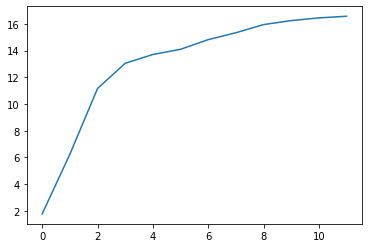

In [18]:
plt.plot(kl_losses)
plt.show()

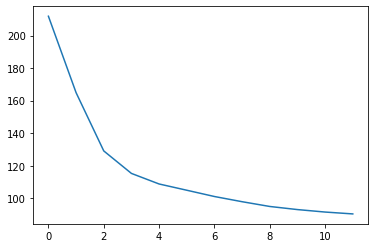

In [19]:
plt.plot(b_losses)
plt.show()

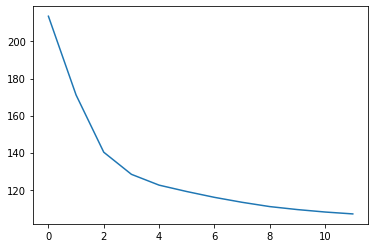

In [20]:
plt.plot(total_losses)
plt.show()

#### Visualize reconstructions for train and test data
In the picture below you can see the reconstruction ability of your network on training and validation data. In each of the two images, the left column is MNIST images and the right column is the corresponding image after passing through autoencoder (or more precisely the mean of the binomial distribution over the output images, since we visualize probabilities).

Note that getting the best possible reconstruction is not the point of VAE, the KL term of the objective specifically hurts the reconstruction performance. But the reconstruction should be anyway reasonable and they provide a visual debugging tool.

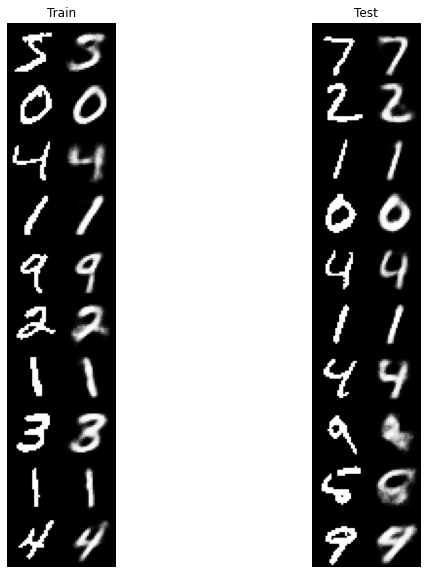

In [21]:
import numpy as np

def plot_samples(train_data, test_data, encoder, decoder, batch_size=10):
    encoder.eval()
    decoder.eval()
    digit_size = 28

    fig = plt.figure(figsize=(10, 10))
    for fid_idx, (data, title) in enumerate(
        zip([train_data, test_data], ['Train', 'Test'])):

        # x_batch = data.tensors[0][:batch_size]
        # your code here
        x_batch = data.tensors[0][:batch_size].to(device)

        mu, sigma = encoder(x_batch)
        z = sample_latent(mu, sigma)
        x_decoded = decoder(z)

        figure = np.zeros((digit_size * batch_size, digit_size * 2))
        for i in range(10):
            #figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_batch[i].detach().numpy().reshape(digit_size, digit_size)
            #figure[i * digit_size: (i + 1) * digit_size, digit_size:] = x_decoded[i].detach().numpy().reshape(digit_size, digit_size)
            # your code here
            figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_batch[i].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size, digit_size:] = x_decoded[i].detach().cpu().reshape(digit_size, digit_size)

        ax = fig.add_subplot(1, 2, fid_idx + 1)
        ax.imshow(figure, cmap='Greys_r')
        ax.set_title(title)
        ax.axis('off')

    plt.show()
    
    
plot_samples(train_data, test_data, encoder, decoder)

### Hallucinating new data

### Task 5
After we trained our model, we may want to generate new samples. In this task you need to implement a function that does this (generation process was described in the beginning).

In [22]:
# Do not actually sample from Bernoulli distribution, such samples can have worse visual quality.
# Instead, just return decoder's output, corresponding to mean values of pixels

def generate_new_samples(decoder, n_samples):
    # your code here
    z = torch.randn((n_samples, d)).to(device)
    mu = decoder(z)
    new_samples = torch.bernoulli(mu)
    return new_samples

Take a look at generated samples. You may expect similar quality as [here](https://drive.google.com/file/d/1fjfLlaFfpyGx_vMxTYSj7EMVUZSoXLg8/view?usp=sharing) (not really great samples, but the neural network's architecture is assumed to be very simple and it's okay for this task).

In [23]:
def show_samples(decoder, n_samples, line_width, scale=15):
    # x = generate_new_samples(decoder, n_samples).detach()
    # your code here
    x = generate_new_samples(decoder, n_samples).detach().cpu()

    plt.figure(figsize=(scale, scale / line_width * (x.shape[0] // line_width + 1)))
    x = x.view(-1, 1, 28, 28)
    mtx = torchvision.utils.make_grid(x, nrow=line_width, pad_value=1)
    plt.imshow(mtx.permute([1, 2, 0]).numpy(), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
    plt.axis('off')

In [24]:
show_samples(decoder, n_samples=20, line_width=10)

### Conditional VAE

Finally, we'll observe an extention of classial VAE : Conditional VAE. In our case, this is a simple way to bring conditioning into model. Now both the likelihood and variational distribution depend on an additional variable, corresponing to the class label. To introduce this dependence we can pass $y$ as an additional input of encoder and decoder:

$$
p_W(x | z) = Ber(x | decoder_W(z)) \rightarrow p_W(x | z, y) = Ber(x | decoder_W(z, y))
$$

$$
q_\phi(z | x) = \mathcal{N}(z | \mu(\phi, x), \sigma(\phi, x)^2) \rightarrow q_\phi(z | x, y) = \mathcal{N}(z | \mu(\phi, x, y), \sigma^2(\phi, x, y))
$$

This allows us to generate new samples of a particular class.

![](https://github.com/RakitinDen/TechnicalRepoFor2Pictures/blob/master/CVAE.png?raw=1)

### Task 6
Implement encoder and decoder for conditional VAE. They could be really similar to your previous implementations and just need to account for an additional input (e.g., via concatenation, torch.cat). Note that numerical representation of class $0,\ldots, 9$ does not make sence, since there is no order (or other relations as between real numbers) between classes. We will use one-hot $y$'s as inputs.

self.label_head is used to produce some hidden learnable 'features' of the given class. You can imagine that as a vector which contains some information about it and used to pass through another network (which is more convenient than just concatinating it with input image). Also, we fix this vector to be of dimension 100. Here, upsampling it from dimension 10 really helps to extract class information.

In [25]:
class ConditionalEncoder(nn.Module):

    # D : number of pixels
    def __init__(self, D, d):
        super(ConditionalEncoder, self).__init__()
        self.D = D
        self.d = d

        self.label_head = nn.Sequential(
            nn.Linear(10, 100),
            nn.ReLU()
        )

        # your code here
        self.hh = D//2
        self.sh = 100

        self.model = nn.Sequential(
            nn.Linear(self.D + self.sh, self.hh),
            nn.LeakyReLU(),
            nn.Linear(self.hh, self.hh),
            nn.LeakyReLU()
        )
        self.mu = nn.Sequential(
            nn.Linear(self.hh, self.d)
        )
        self.logsigma = nn.Sequential(
            nn.Linear(self.hh, self.d)
        )

    # x : batch_size x D, batch of images stretched into vector
    # y : batch_size x 10, batch of one-hot-encoded class labels
    # output: mu, sigma, both of shape batch_size x d, parameters of variational distribution
    def forward(self, x, y):
        hidden_y = self.label_head(y)
        x_y = torch.cat([x, hidden_y], dim=-1) # batch_size x (D + 100), x concatenated with processed y

        #mu_sigma = self.model(x_y) # batch_size x 2d
        #mu, sigma = mu_sigma[:, :self.d], mu_sigma[:, self.d:]

        # your code here
        h = self.model(x_y)
        mu = self.mu(h)
        sigma = self.logsigma(h)

        return mu, F.softplus(sigma)


class ConditionalDecoder(nn.Module):

    def __init__(self, D, d):
        super(ConditionalDecoder, self).__init__()
        self.D = D
        self.d = d

        self.label_head = nn.Sequential(
            nn.Linear(10, 100),
            nn.ReLU()
        )

        self.sigmoid = nn.Sigmoid() # probabilities should be from 0 to 1

        # your code here
        self.hh = D//2
        self.sh = 100

        self.model = nn.Sequential(
            nn.Linear(self.d + self.sh, self.hh),
            nn.LeakyReLU(),
            nn.Linear(self.hh, self.hh),
            nn.LeakyReLU()
        )
        self.mu = nn.Sequential(
            nn.Linear(self.hh, self.D),
            nn.Sigmoid()
        )

    # z : batch_size x d, batch of latent variables
    # y : batch_size x 10, batch of one-hot-encoded class labels
    # output : batch_size x D, batch of parameters of Bernoulli distribution
    def forward(self, z, y):
        hidden_y = self.label_head(y)
        z_y = torch.cat([z, hidden_y], dim=-1) # batch_size x (d + 100), z concatenated with processed y

        x_logits = self.model(z_y)
        # x = self.sigmoid(x_logits)
        # your code here
        x = self.mu(x_logits)
        return x

### Task 7.

Run the following code for training your conditional model. You may need to change learning rate of the optimizer, batch size or number of epochs for training depending on architectures of encoder and decoder. However your code should work fine with these parameters.

In [26]:
D = 28 * 28
d = 10

In [27]:
# You can change those parameters for experiments
batch_size = 64
lr = 1e-4
num_epochs = 12

In [28]:
cond_encoder = ConditionalEncoder(D, d)
cond_decoder = ConditionalDecoder(D, d)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

opt_cond_enc = torch.optim.Adam(cond_encoder.parameters(), lr=lr)
opt_cond_dec = torch.optim.Adam(cond_decoder.parameters(), lr=lr)

In [29]:
# your code here
cond_encoder.to(device)
cond_decoder.to(device)

ConditionalDecoder(
  (label_head): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): ReLU()
  )
  (sigmoid): Sigmoid()
  (model): Sequential(
    (0): Linear(in_features=110, out_features=392, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=392, out_features=392, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (mu): Sequential(
    (0): Linear(in_features=392, out_features=784, bias=True)
    (1): Sigmoid()
  )
)

In [30]:
# your code here
cond_kl_losses = []
cond_b_losses = []
cond_total_losses = []

def train_cond(dataloader, encoder, decoder, opt_enc, opt_dec, num_epochs):
    encoder.train()
    decoder.train()
    for epoch in range(num_epochs):
        # your code here
        bs = 0 
        kls = 0

        with tqdm(dataloader) as iterator:
            for batch in iterator:
                # X_batch, y_batch = batch
                # your code here
                X_batch, y_batch = batch
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                y_batch = F.one_hot(y_batch, 10).float()
                q_mu, q_sigma = encoder(X_batch, y_batch)
                z = sample_latent(q_mu, q_sigma)
                dec_output = decoder(z, y_batch)

                #vlb = batch_vlb(X_batch, dec_output, q_mu, q_sigma)
                #loss = -vlb.mean()
                # your code here
                bernoulli_ll,  kl_loss = batch_vlb(X_batch, dec_output, q_mu, q_sigma)
                loss = -(bernoulli_ll - kl_loss)

                # your code here
                bs += -bernoulli_ll.item() / len(iterator)
                kls += kl_loss.item() / len(iterator)

                opt_enc.zero_grad()
                opt_dec.zero_grad()
                loss.backward()
                opt_enc.step()
                opt_dec.step()
                # iterator.set_description('Train loss: %.3f' % loss.item())
                # your code here
                iterator.set_description('Train loss: %.3f, epoch: %d, %.3f, %.3f' % (loss.item(), epoch, bs, kls))
        
        cond_kl_losses.append(kls)
        cond_b_losses.append(bs)
        cond_total_losses.append(bs + kls)

In [31]:
# train_cond(train_dataloader, cond_encoder, cond_decoder, opt_cond_enc, opt_cond_dec, num_epochs)
# your code here
train_cond(train_dataloader, cond_encoder, cond_decoder, opt_cond_enc, opt_cond_dec, num_epochs=num_epochs)

Train loss: 97.536, epoch: 11, 87.404, 13.402: 100%|██████████| 938/938 [00:07<00:00, 124.16it/s]


In [32]:
# your code here

In [33]:
plt.plot(cond_kl_losses)
plt.show()

In [34]:
plt.plot(cond_b_losses)
plt.show()

In [35]:
plt.plot(cond_total_losses)
plt.show()

### Task 8.
Finally, implement function that produces new samples (analogous with function from Task 5) given class labels.

Important: target is a batch of one-hot vectors of class labels.

In [36]:
def generate_samples_conditional(decoder, target):
    # target(y): tensor of shape batch_size x 10
    # here, target_k,i = 1 if and only if we want k'th sample to be a picture of digit i (otherwise target_k,i = 0)

    # your code here

    z = torch.randn((target.size()[0], d), device=device)
    mu = decoder(z, target.to(device))
    return torch.bernoulli(mu)

In [37]:
def plot_samples(train_data, test_data, encoder, decoder, batch_size=10):
    encoder.eval()
    decoder.eval()
    digit_size = 28

    fig = plt.figure(figsize=(10, 10))
    for fid_idx, (data, title) in enumerate(
        zip([train_data, test_data], ['Train', 'Test'])):

        x_batch = data.tensors[0][:batch_size]

        mu, sigma = encoder(x_batch)
        z = sample_latent(mu, sigma)
        x_decoded = decoder(z)

        figure = np.zeros((digit_size * batch_size, digit_size * 2))
        for i in range(10):
            figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_batch[i].detach().numpy().reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size, digit_size:] = x_decoded[i].detach().numpy().reshape(digit_size, digit_size)

        ax = fig.add_subplot(1, 2, fid_idx + 1)
        ax.imshow(figure, cmap='Greys_r')
        ax.set_title(title)
        ax.axis('off')

    plt.show()

In [38]:
def show_samples_cond(decoder, n_samples=10):
    decoder.eval()
    digit_size = 28

    fig = plt.figure(figsize=(10, 10))
    global_idx = 0

    target = torch.eye(10)
    for digit in range(10):
        cur_target = target[digit].unsqueeze(0).repeat(n_samples, 1)
        # cur_images = generate_samples_conditional(decoder, cur_target).detach()
        # your code here
        cur_images = generate_samples_conditional(decoder, cur_target).detach().cpu()
        for i in range(n_samples):
            ax = plt.subplot(10, n_samples, global_idx + 1)
            plt.imshow(cur_images[i].reshape(28, 28), cmap='gray')
            ax.axis('off')
            global_idx += 1
    plt.show()


Code below will produce samples from your trained conditional VAE. Each row will correspond to samples from a fixed class (i.e. first row - samples of zeros, etc). You can find example of samples' quality [here](https://drive.google.com/file/d/1r90FhrNLmgT7RdoJYMTmt3f1xu41Oj7P/view?usp=sharing) (not really great samples, but the neural network's architecture is assumed to be very simple and it's okay for this task).

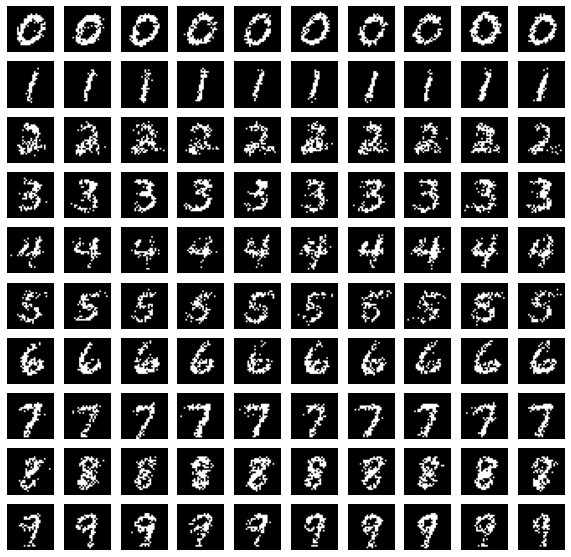

In [39]:
show_samples_cond(cond_decoder)

In [40]:
pass